In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import nibabel as nib
import os
import sys
import glob
import itertools
from pathlib import Path
cd= Path.cwd().parent.parent
print(cd)
sys.path.append(str(cd))
from func.Models import VAE
from func.Models import MultiTaskNet_ag as MultiTaskNet
from func.dataloads import LiverUnlabeledDataset, LiverDataset
from torch.utils.data import DataLoader

INPUT_SHAPE = (128, 128,128) # ( D, H, W)
NUM_CLASSES = 3  # Background, Segment 1, Segment 2
LATENT_DIM = 256 # RNN batch
BATCH_SIZE = 4
TIME_STEPS = 10 # Time series size 


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"--- Using device: {device} ---") # Good to confirm this says 'cpu'
MODEL_PATH = Path.cwd().parent.parent / "Trained_models" /"AG.pth"
print(f"Model path: {MODEL_PATH}")

Test_dir = Path.cwd().parent.parent / "Task03_Liver_rs" 

model = MultiTaskNet(
    in_channels=1, 
    num_classes=NUM_CLASSES, 
    latent_dim=LATENT_DIM    
).to(device)
#model = AutoencoderNet(in_channels=1).to(device)
#model = MultiTaskNet(in_channels=1, num_classes=NUM_CLASSES).to(device)
#model = VAE(
#    in_channels=1, 
#    latent_dim=LATENT_DIM, 
#    NUM_CLASSES=NUM_CLASSES).to(device)

model.load_state_dict(torch.load(MODEL_PATH, map_location=device))

print(f"Loaded model weights from {MODEL_PATH}")

model.eval() 

labeled_dataset = LiverDataset(Test_dir, Test_dir, target_size= INPUT_SHAPE)
test_loader = DataLoader(labeled_dataset, batch_size=1, shuffle=True)

# Unpack both the image and the target mask
x_labeled, y_labeled = next(iter(test_loader))

# Move them to the device
x_labeled = x_labeled.to(device)
y_labeled = y_labeled.to(device)

print(f"Loaded one labeled image with shape: {x_labeled.shape}")

with torch.no_grad(): # We don't need to calculate gradients
     seg_out, recon= model(x_labeled)

print(f"Segmentation output shape: {seg_out.shape}")
print(f"Reconstruction output shape: {recon.shape}")


/zhome/d2/4/167803/Desktop/Deep_project/02456-final-project
--- Using device: cpu ---
Model path: /zhome/d2/4/167803/Desktop/Deep_project/02456-final-project/Trained_models/AG.pth
Loaded model weights from /zhome/d2/4/167803/Desktop/Deep_project/02456-final-project/Trained_models/AG.pth
/zhome/d2/4/167803/Desktop/Deep_project/02456-final-project/Task03_Liver_rs
/zhome/d2/4/167803/Desktop/Deep_project/02456-final-project/Task03_Liver_rs
Found 28 image/label pairs.
Loaded one labeled image with shape: torch.Size([1, 1, 128, 128, 128])


/tmp/ipykernel_663314/1222734328.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=device))


Segmentation output shape: torch.Size([1, 3, 128, 128, 128])
Reconstruction output shape: torch.Size([1, 1, 128, 128, 128])


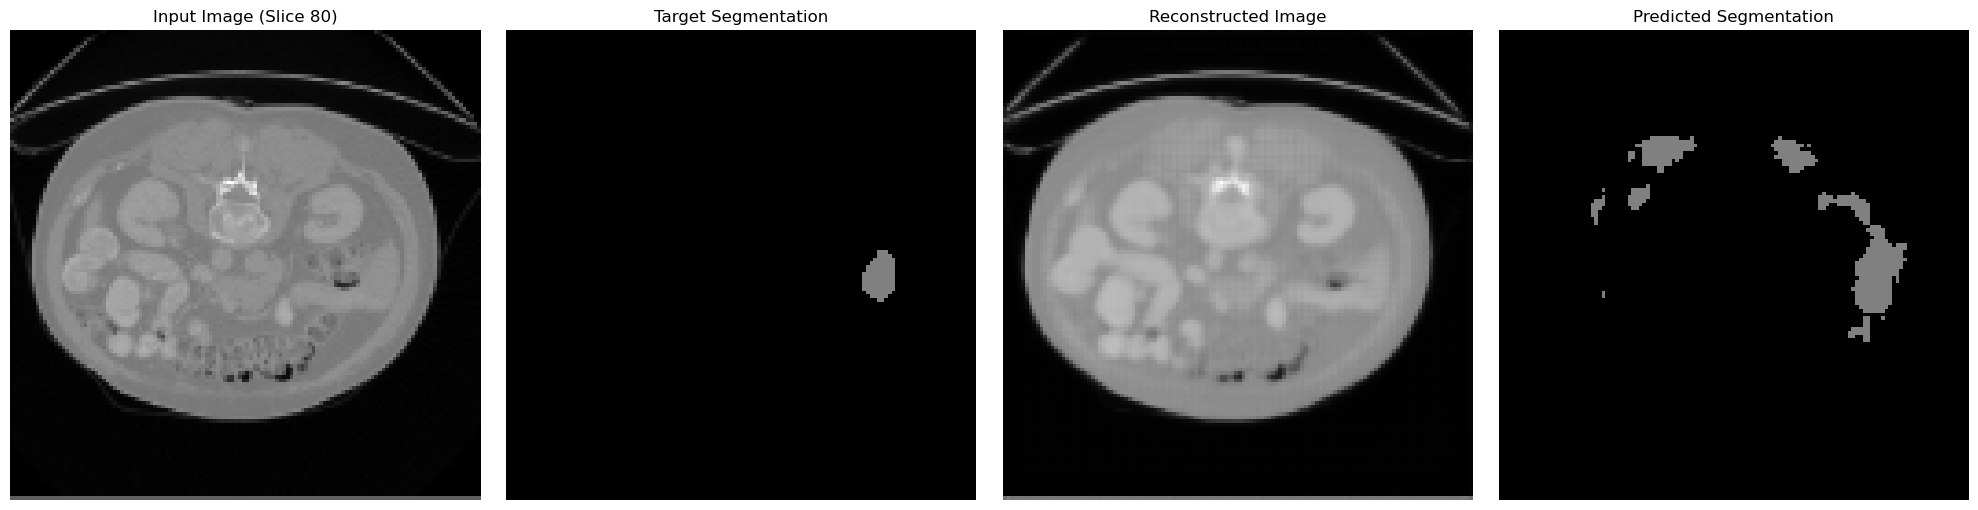

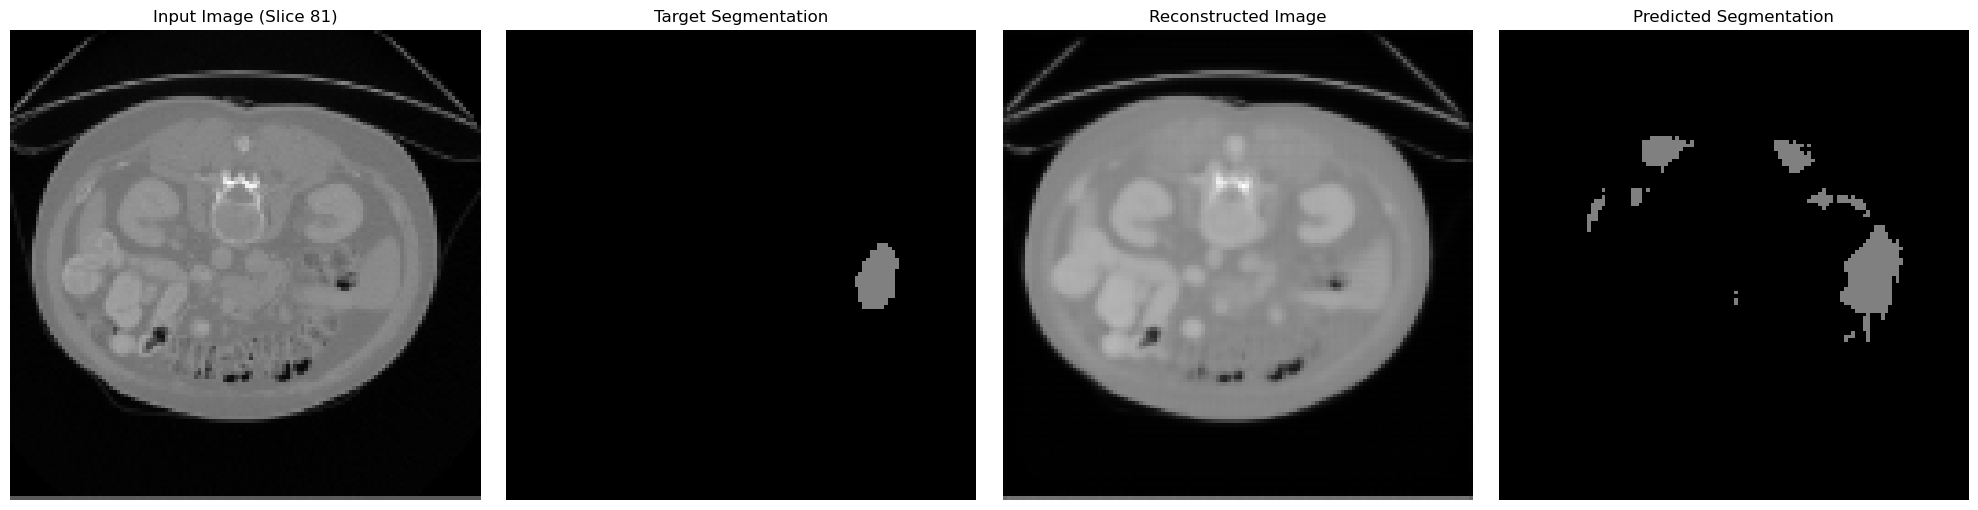

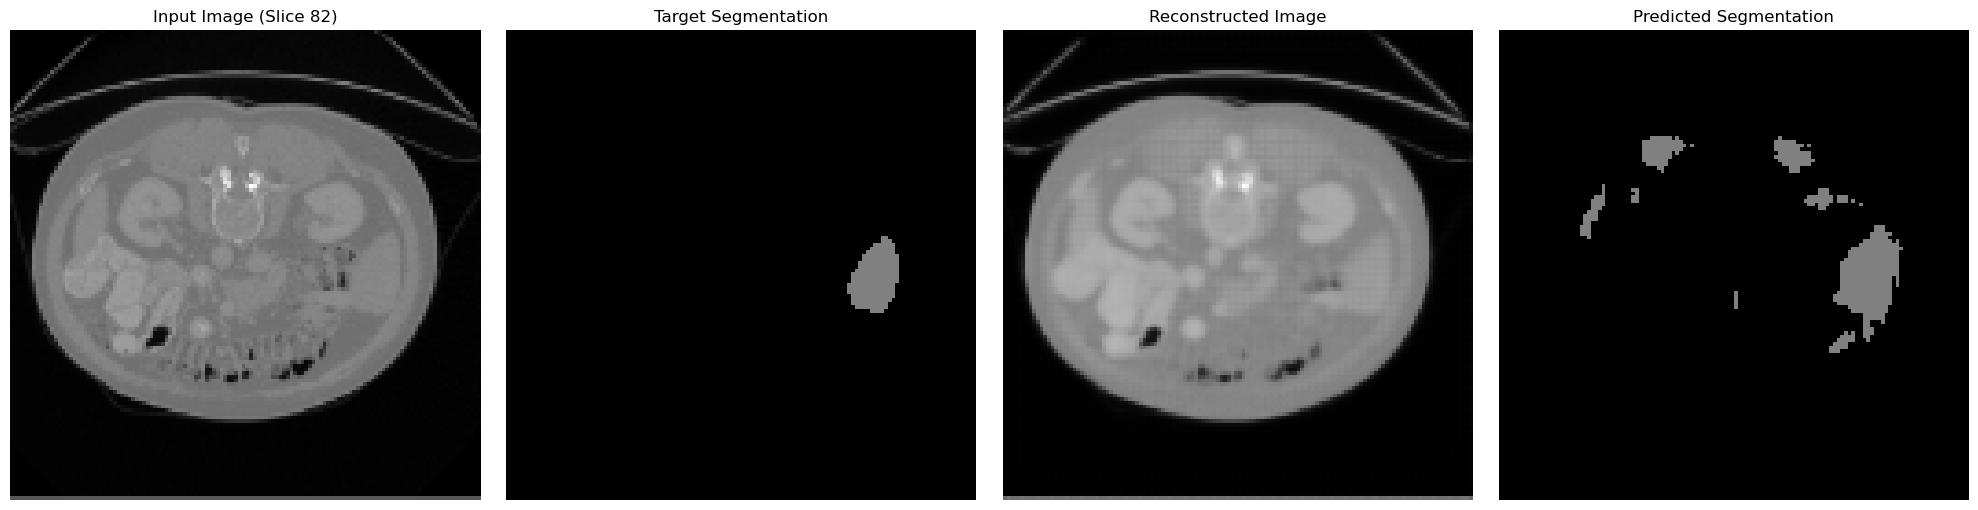

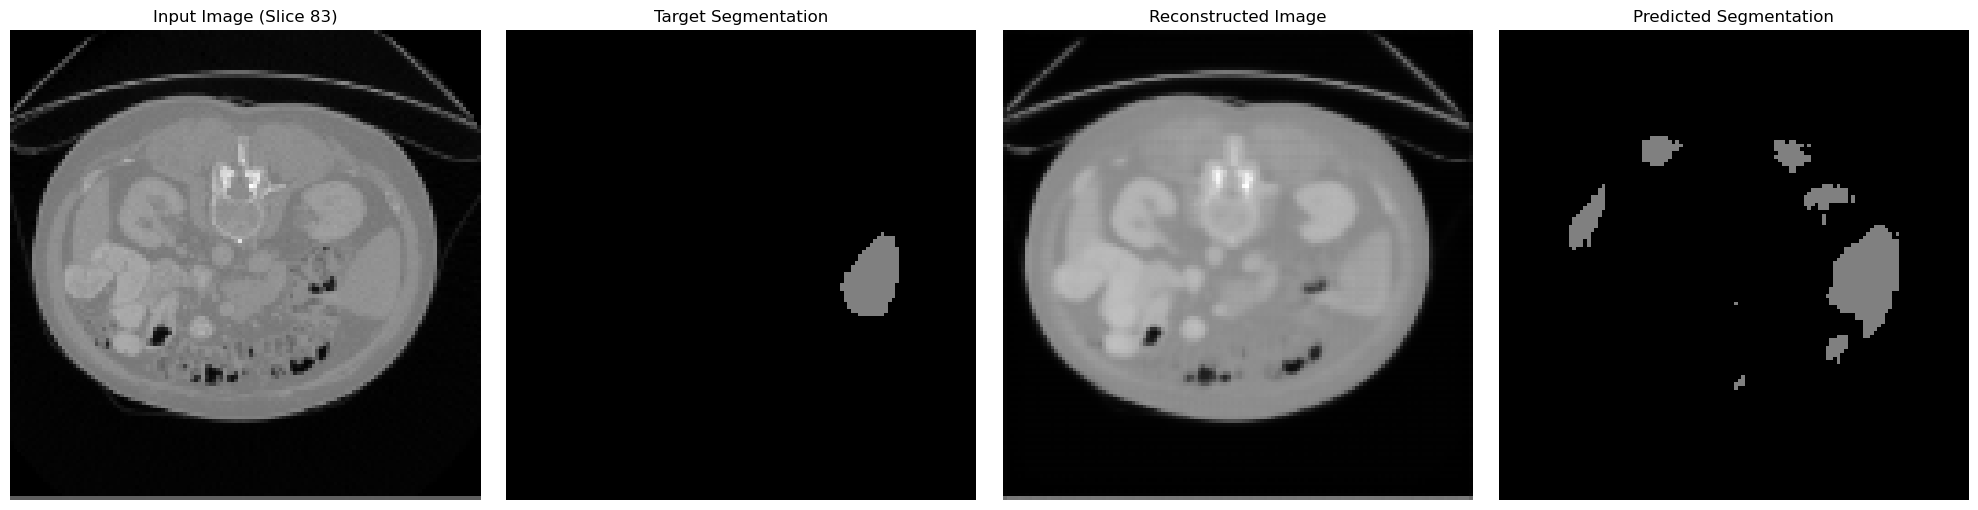

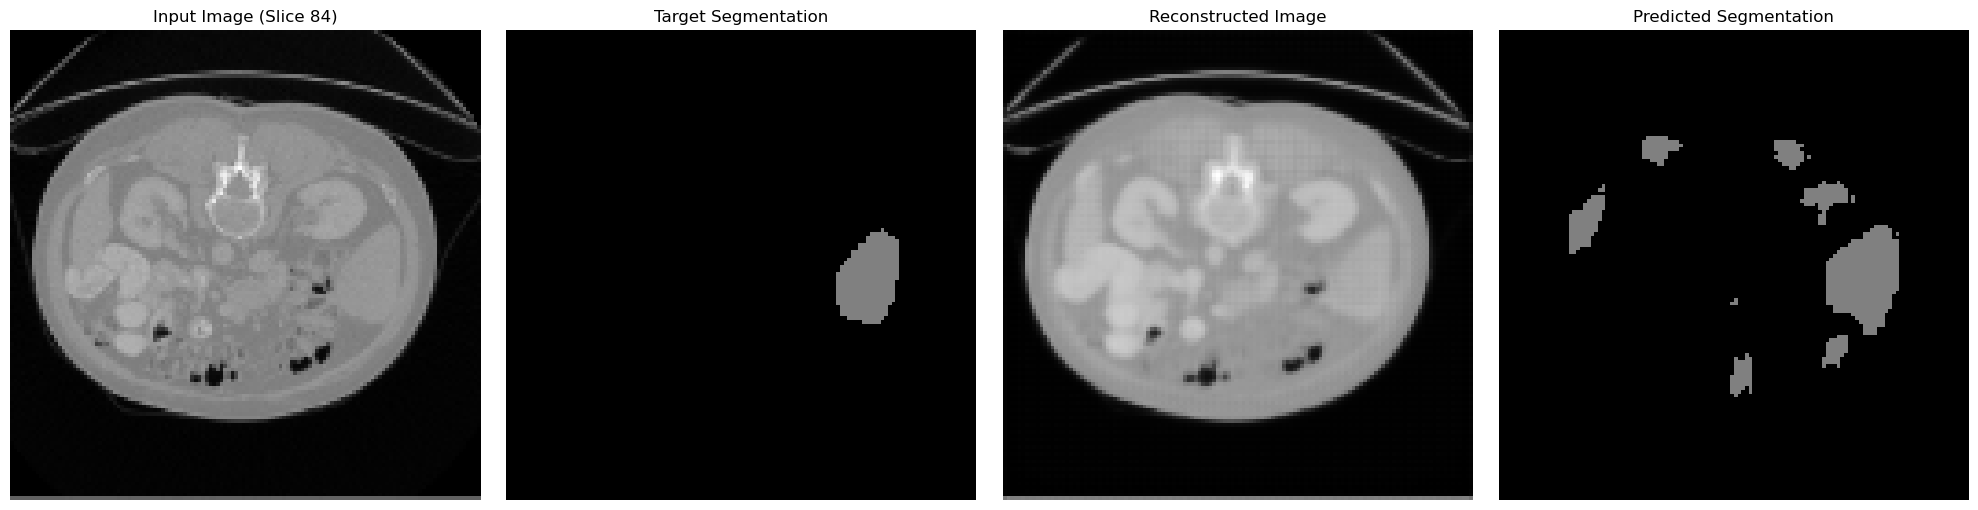

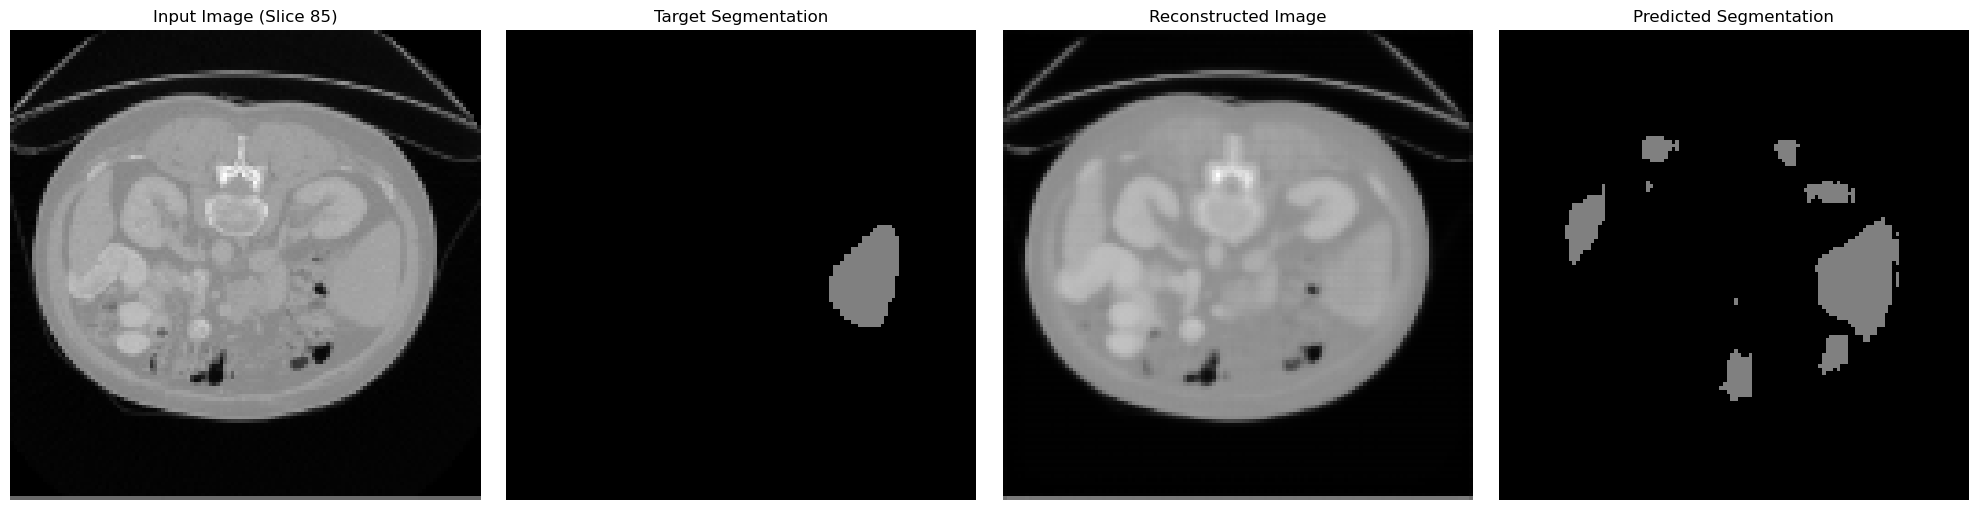

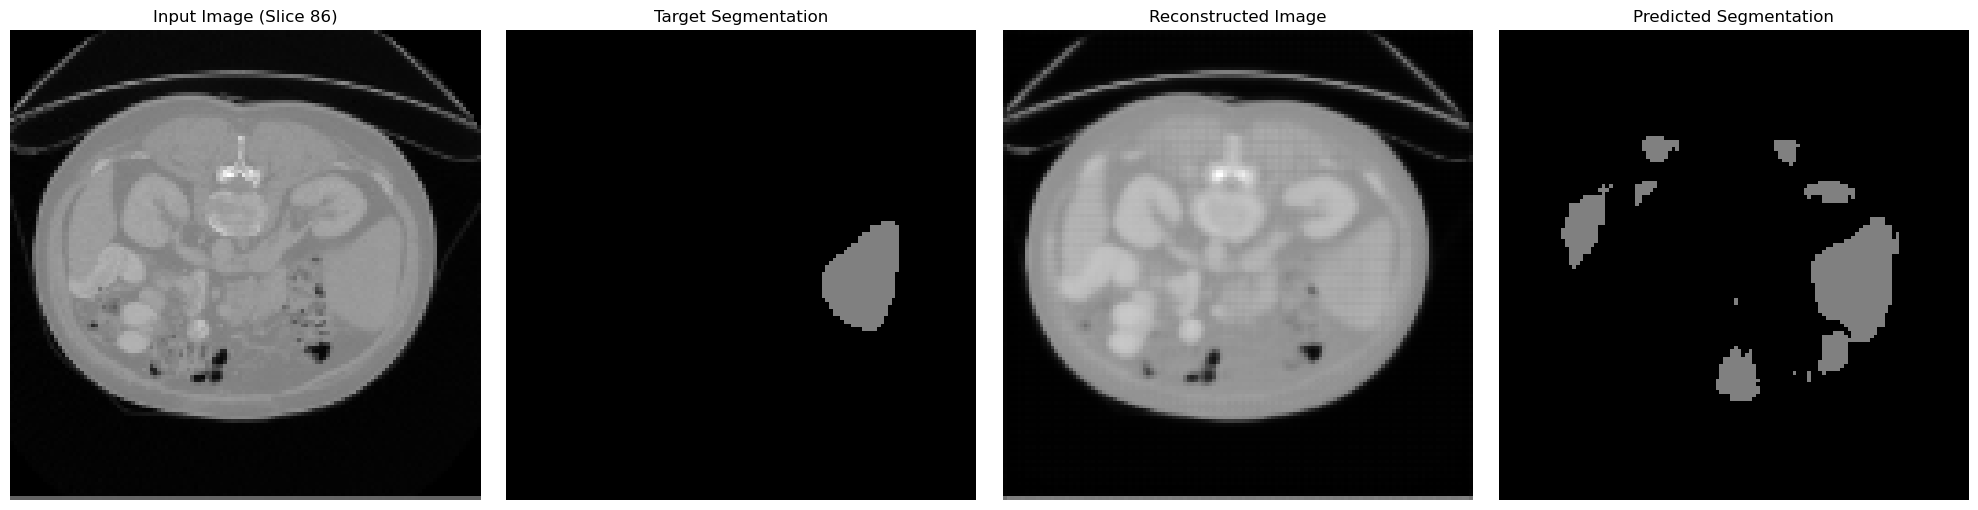

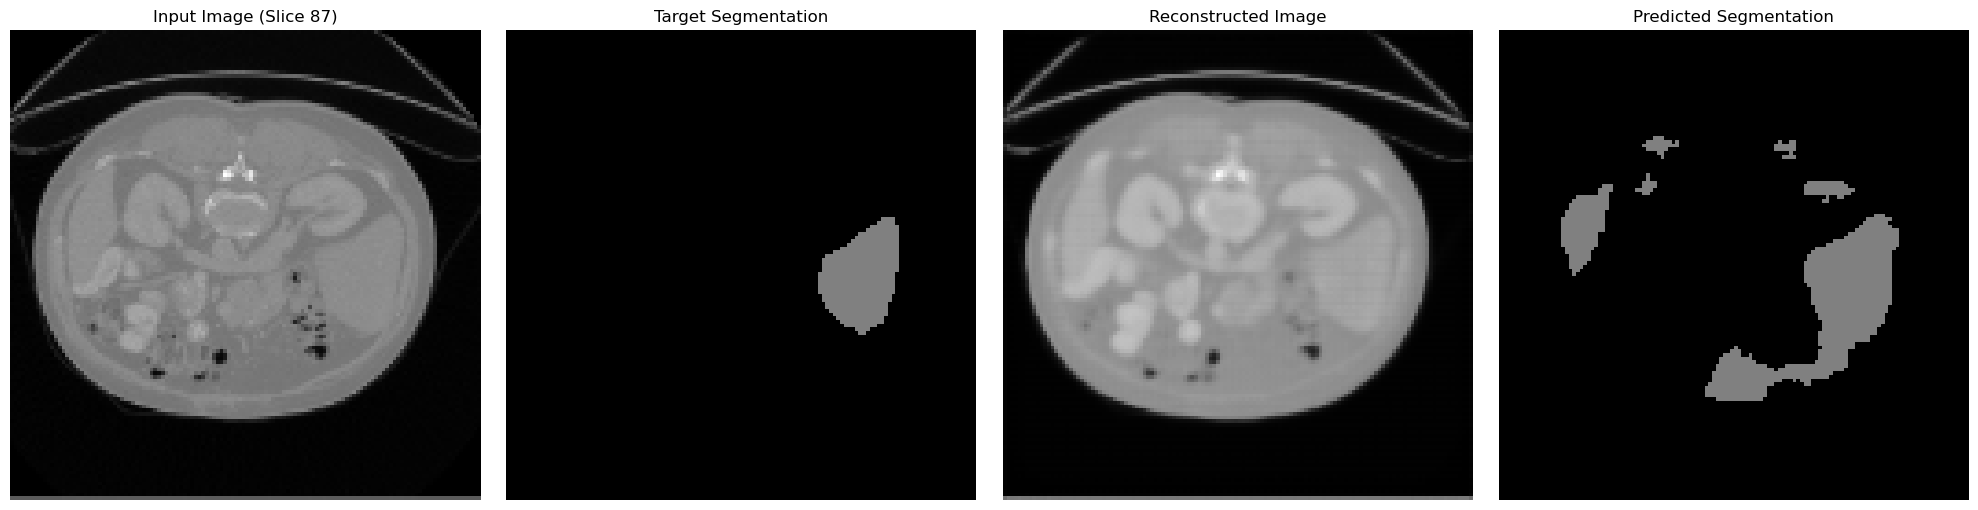

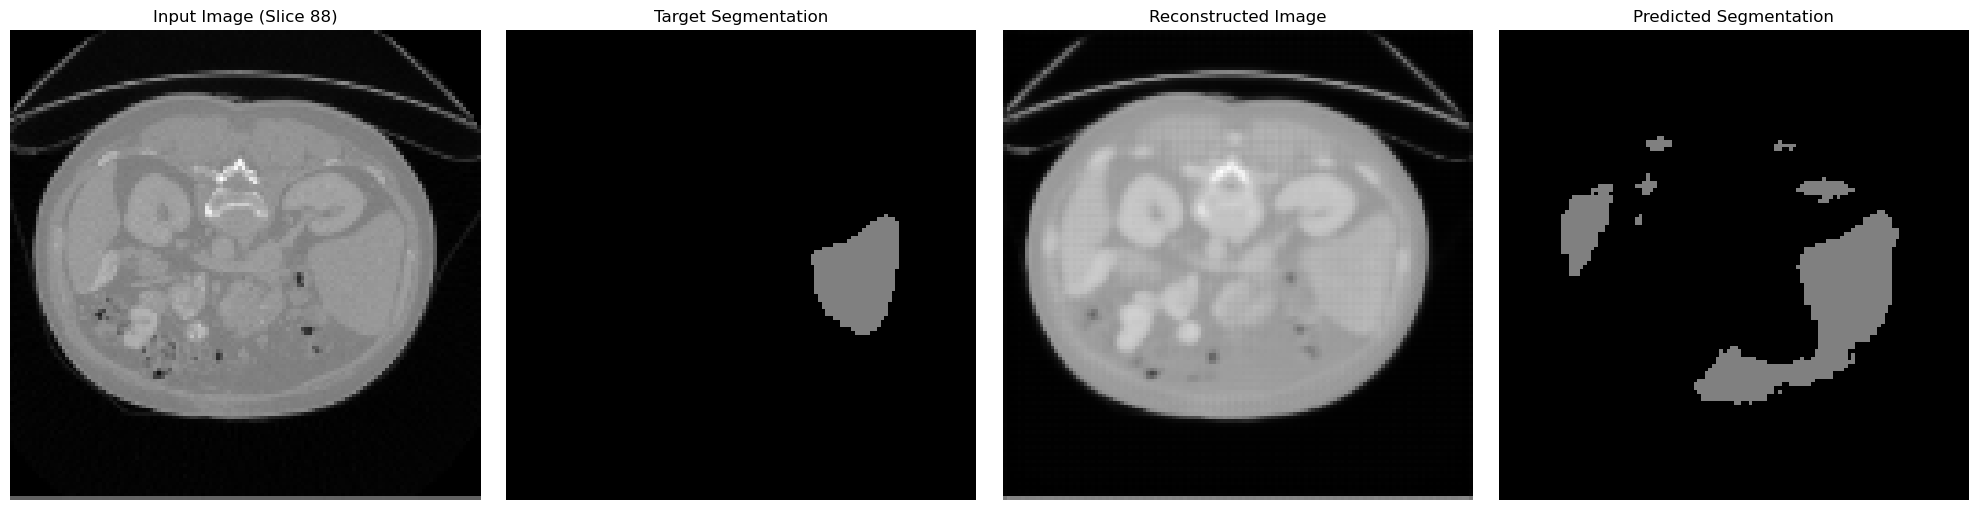

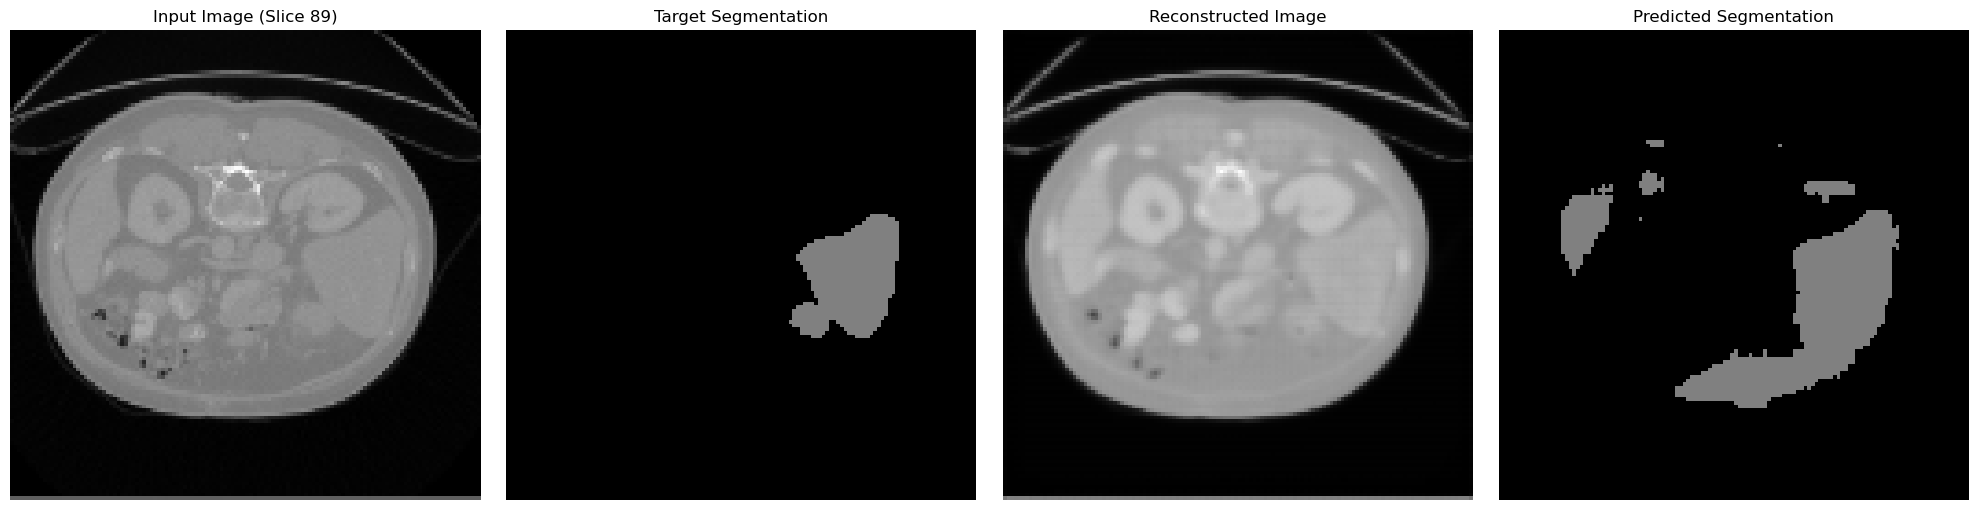

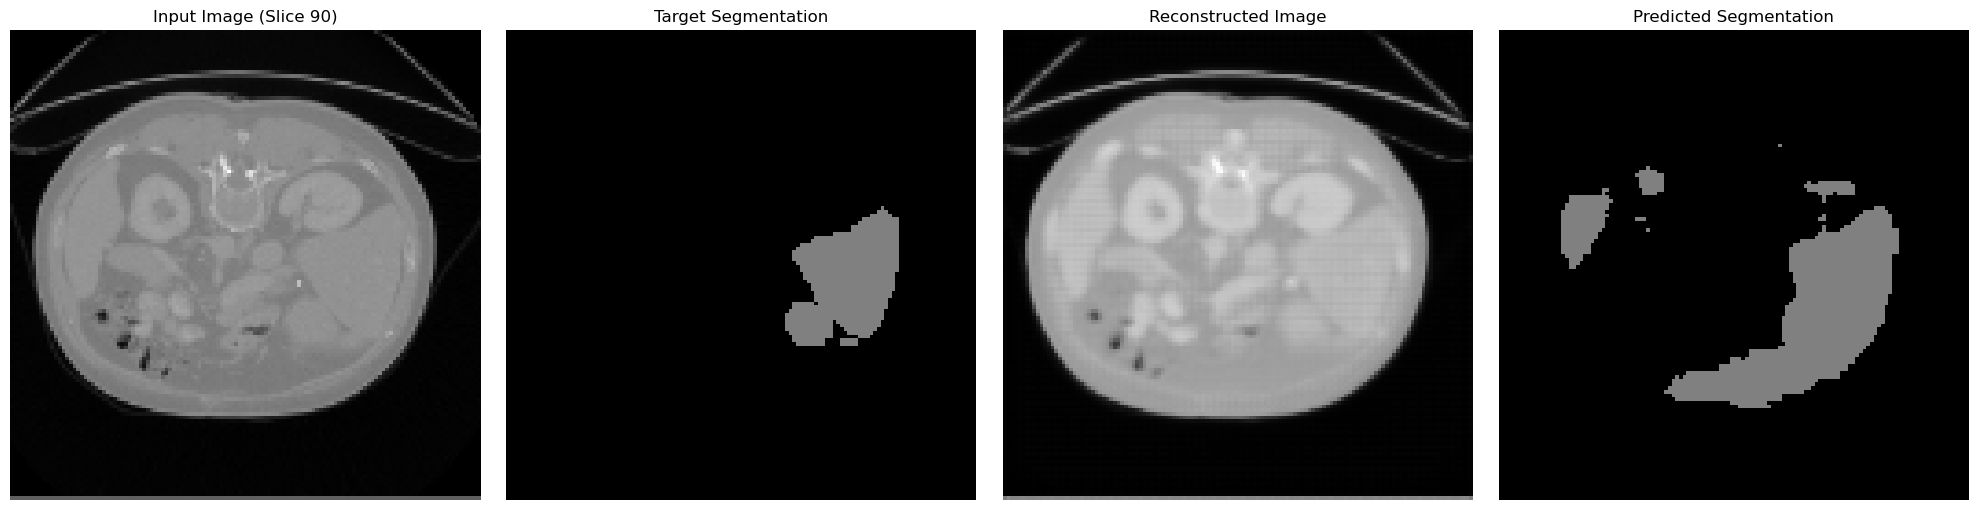

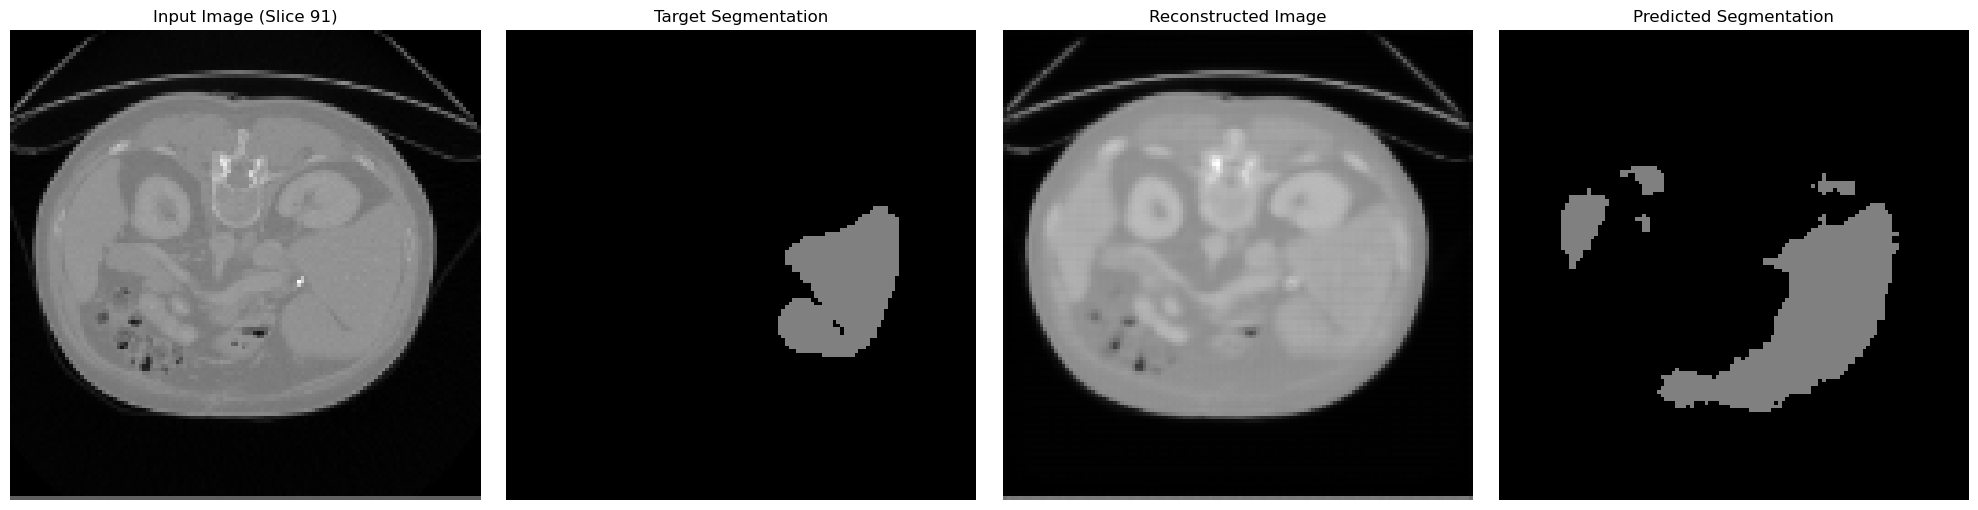

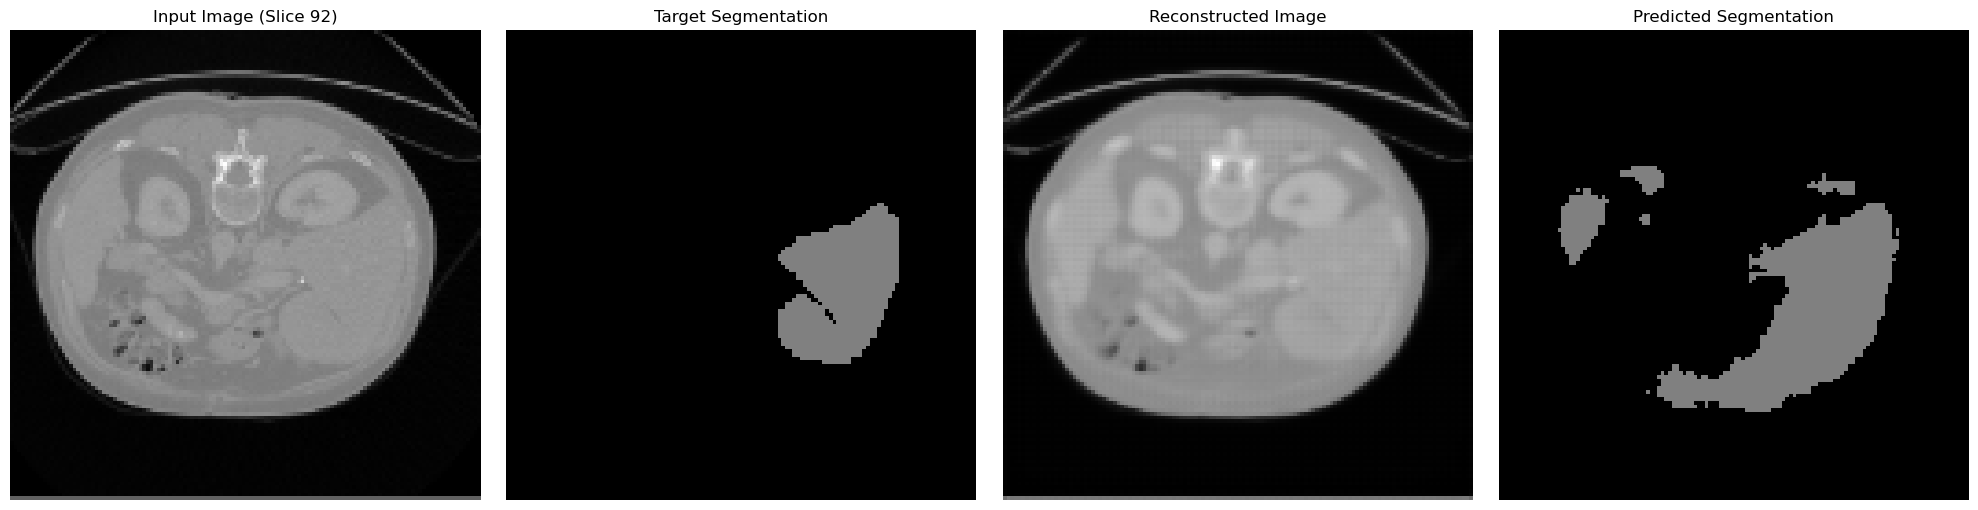

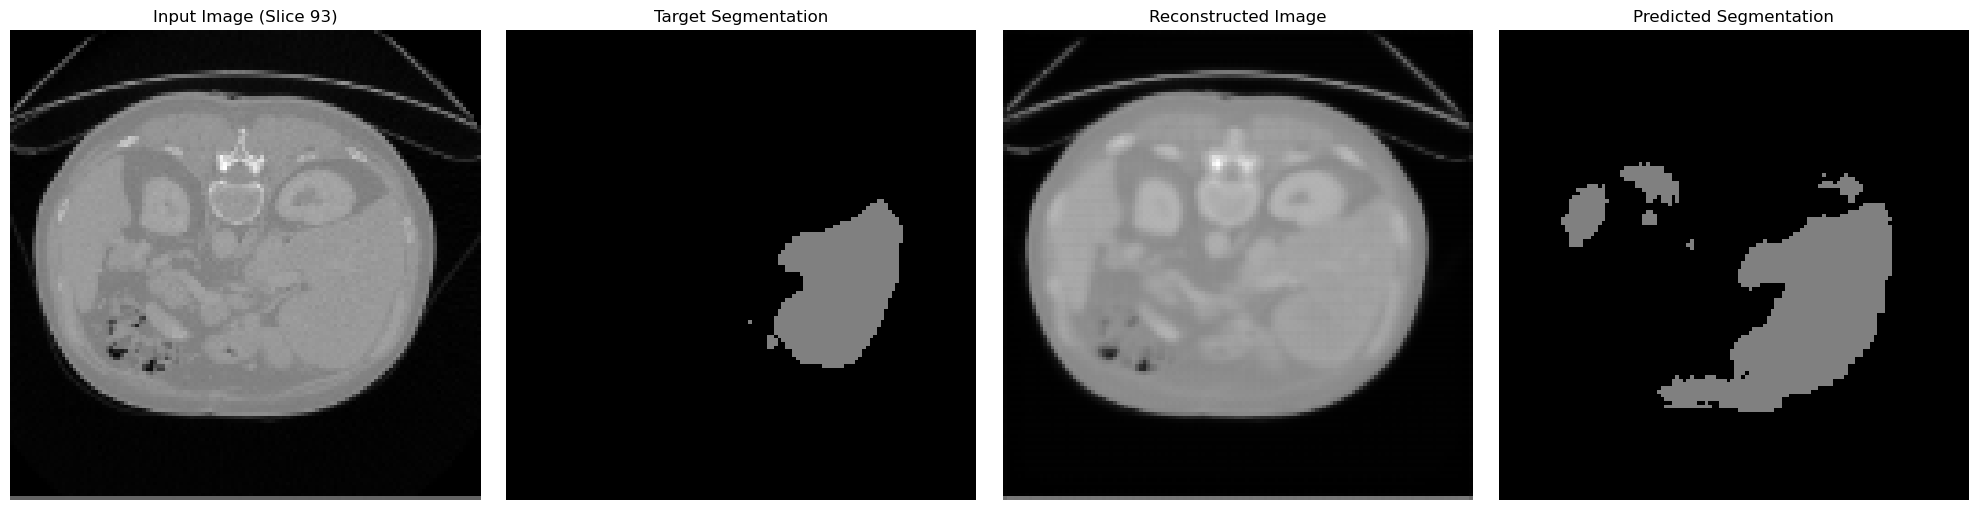

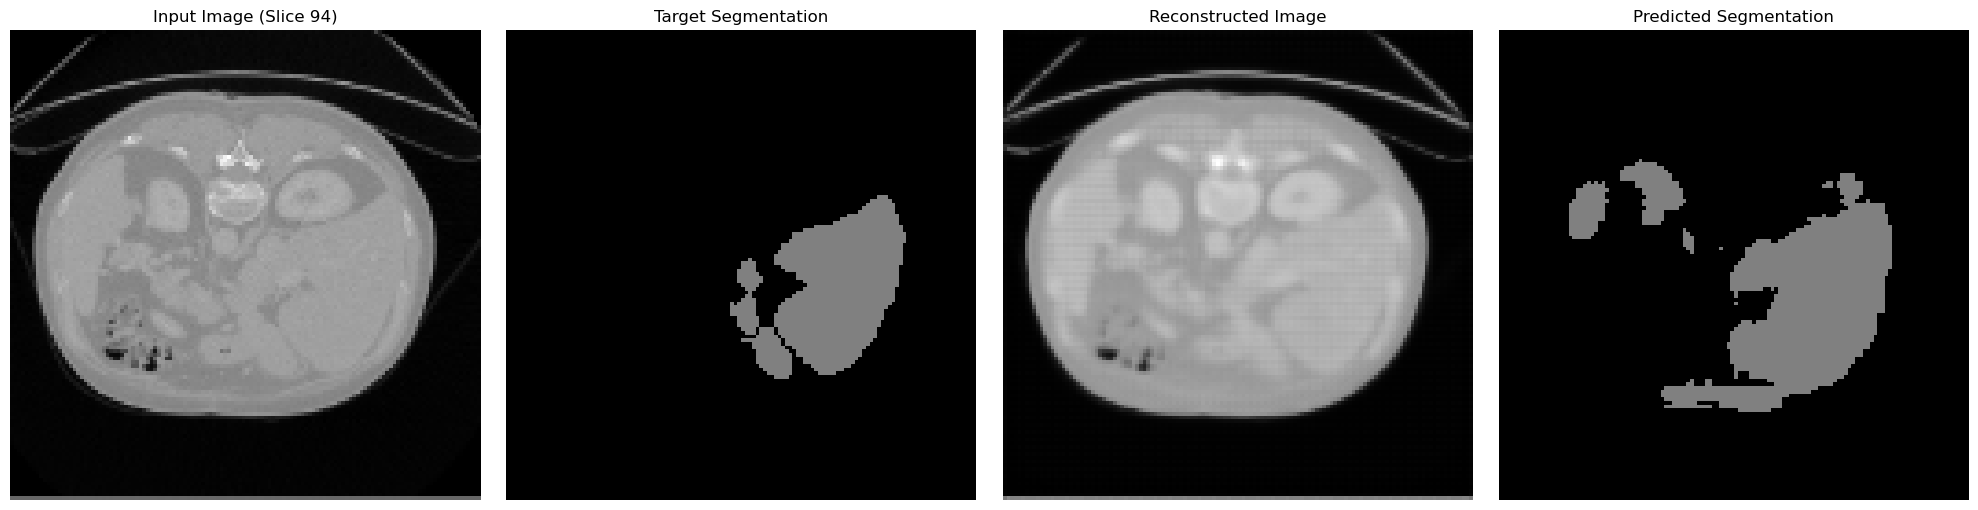

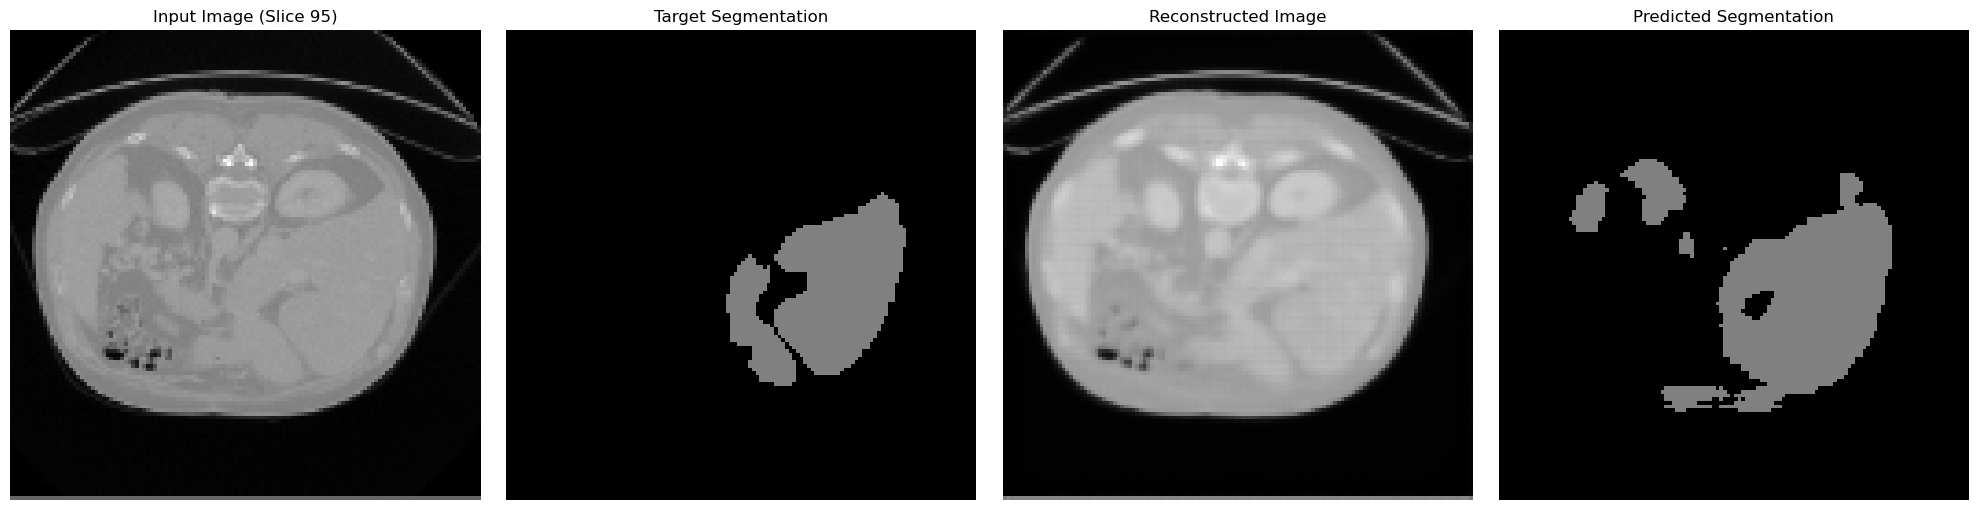

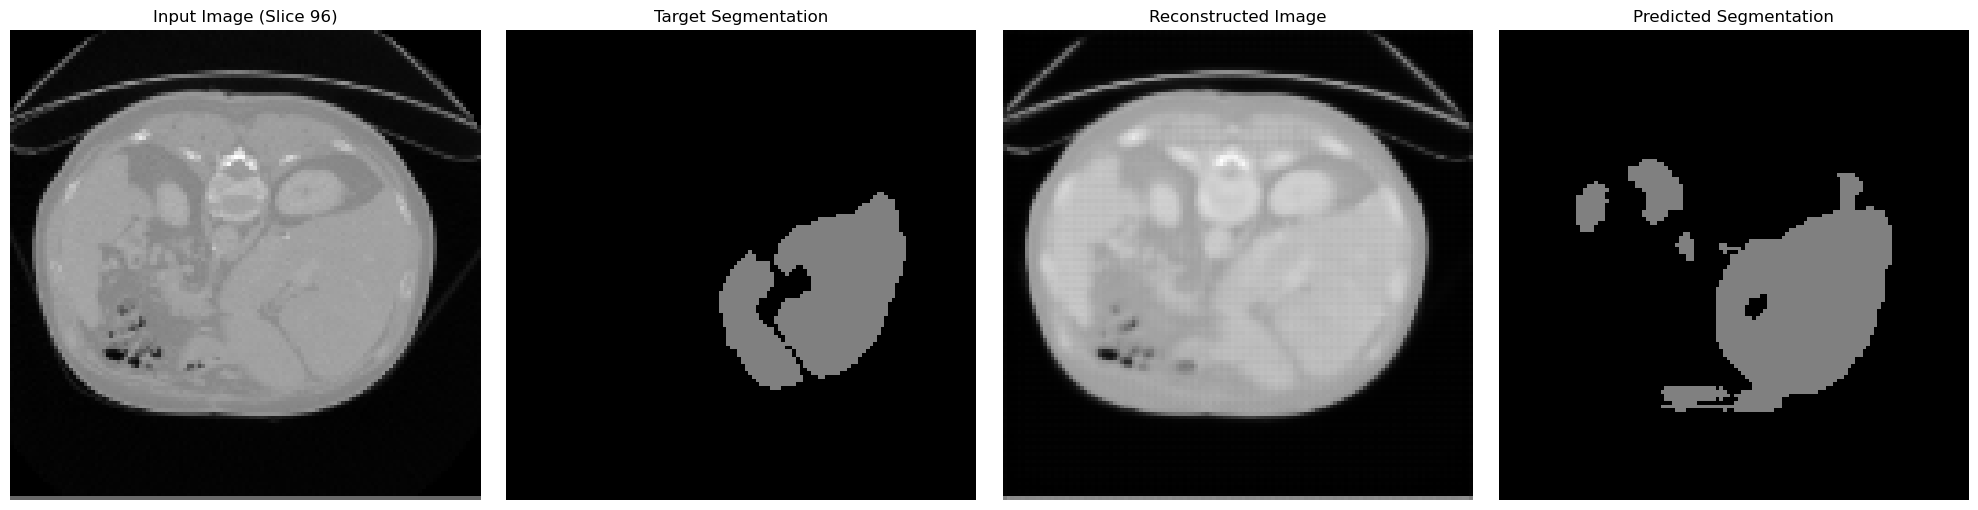

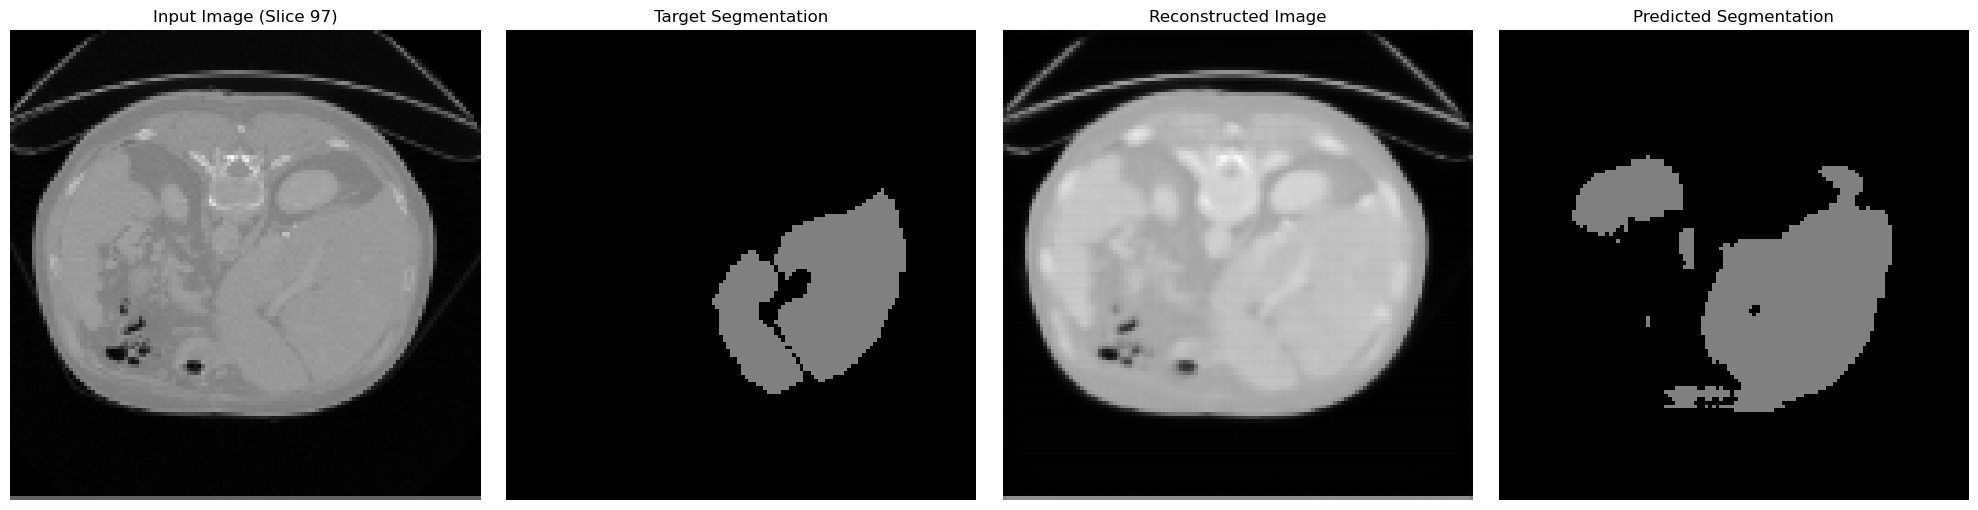

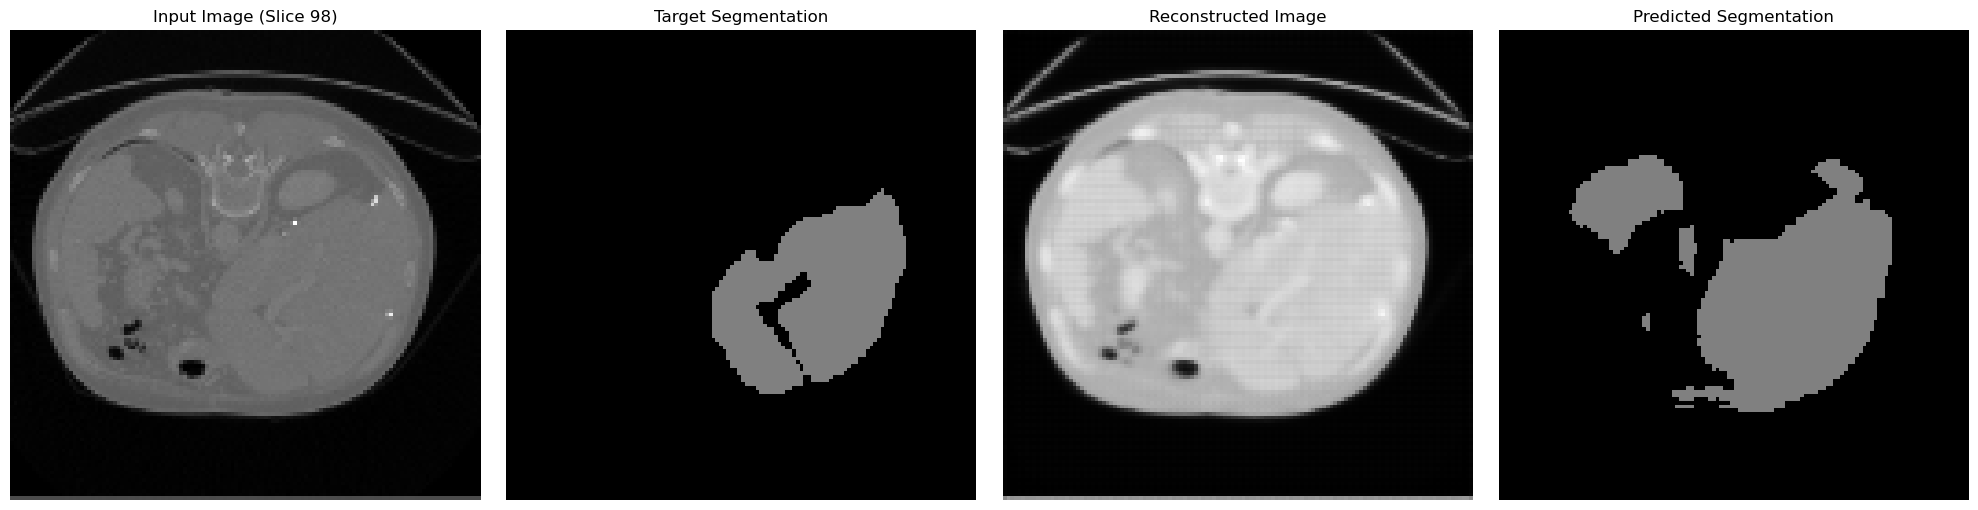

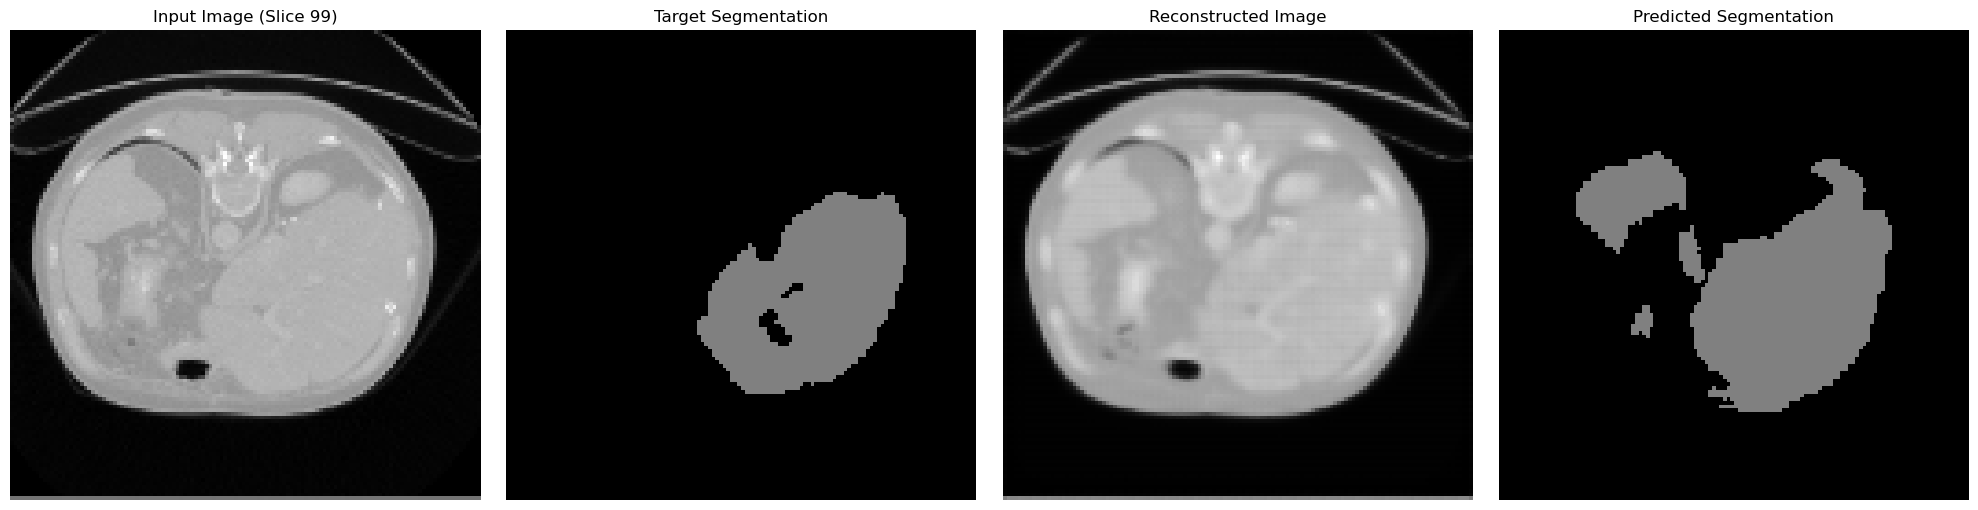

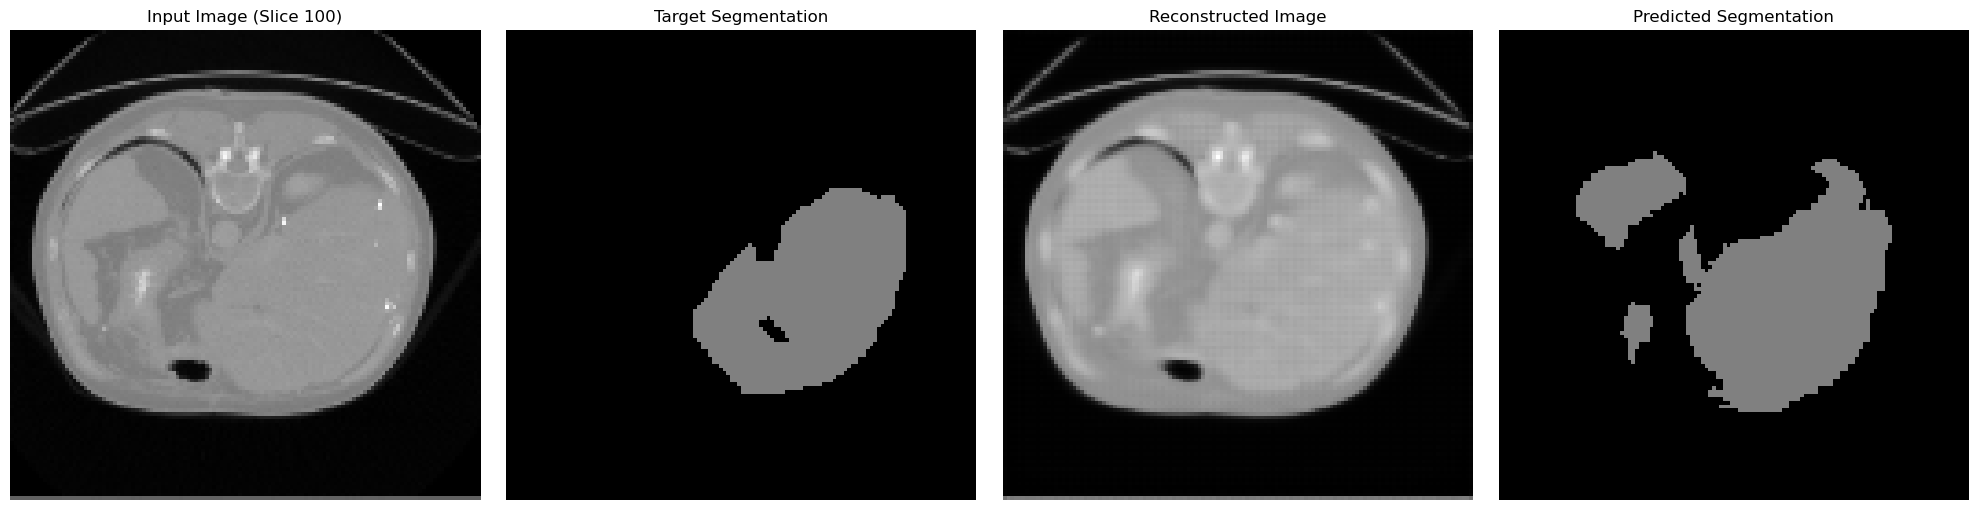

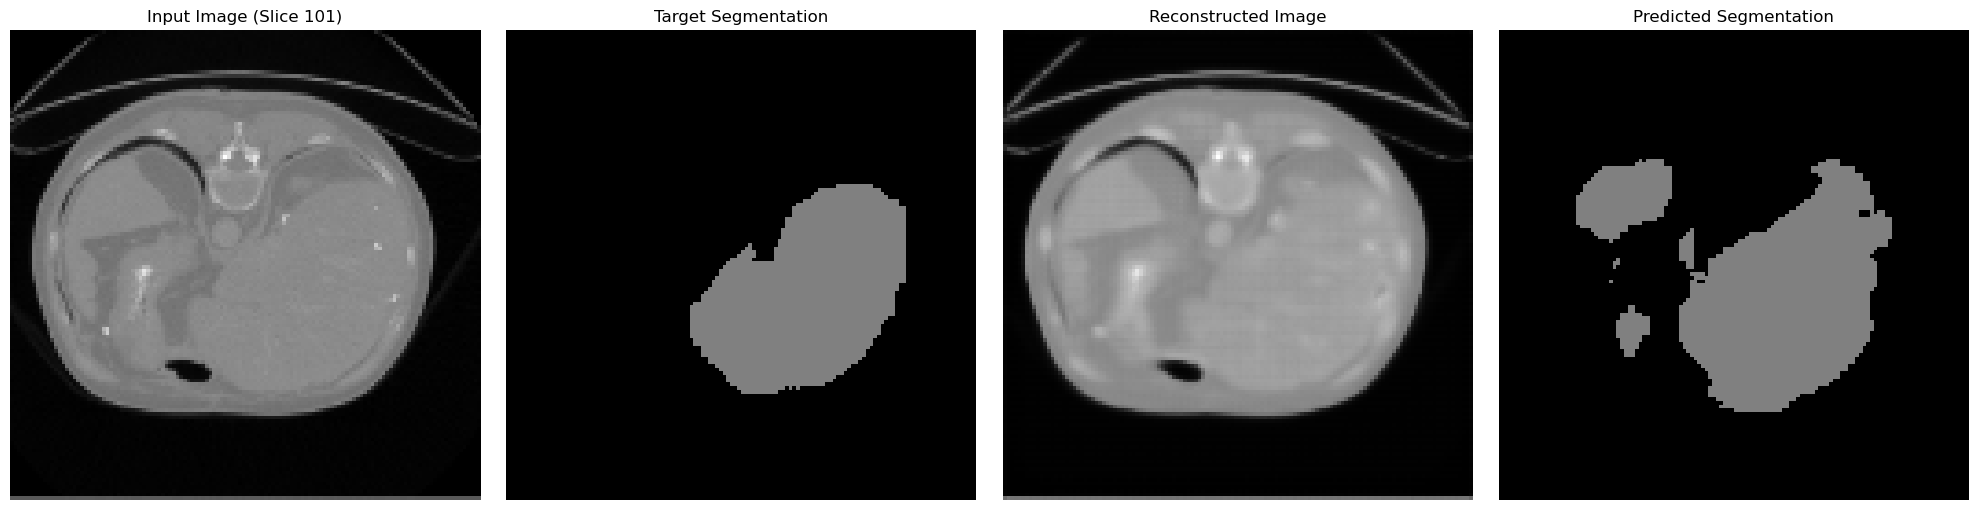

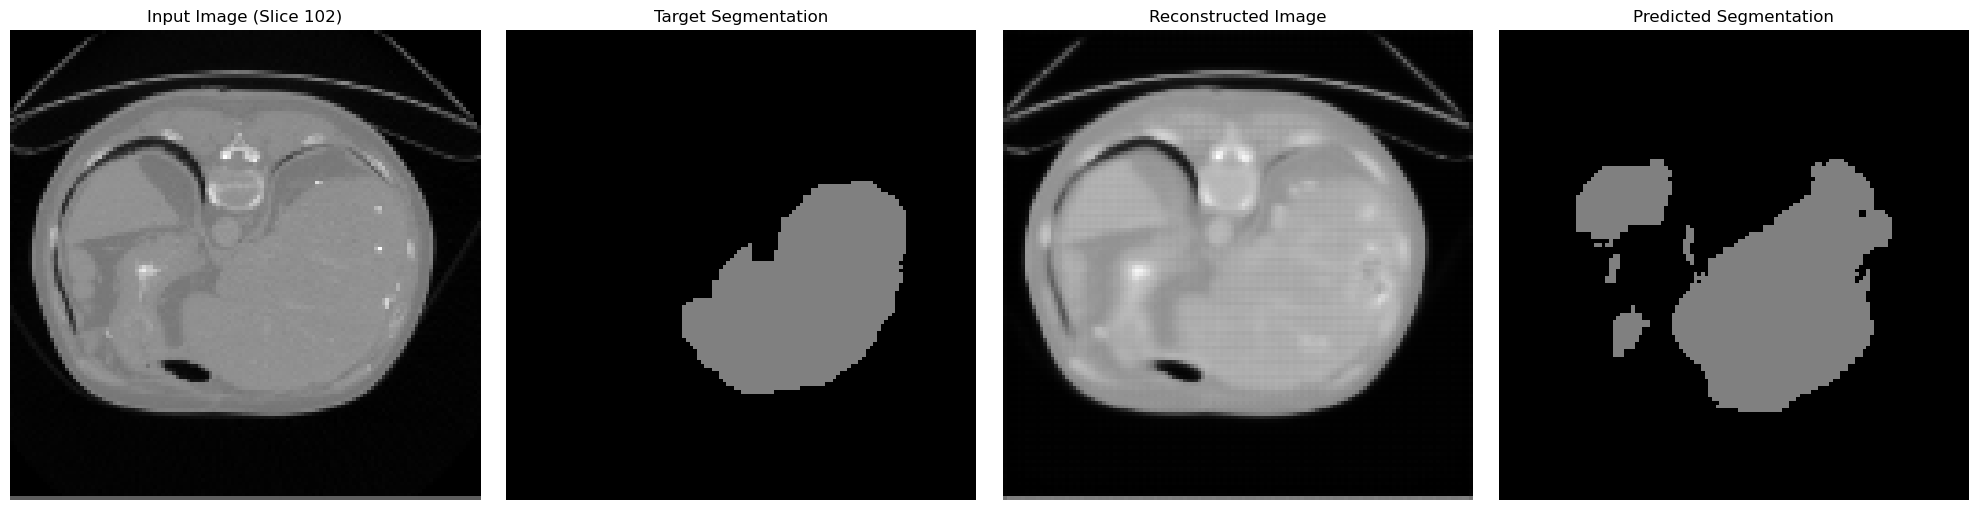

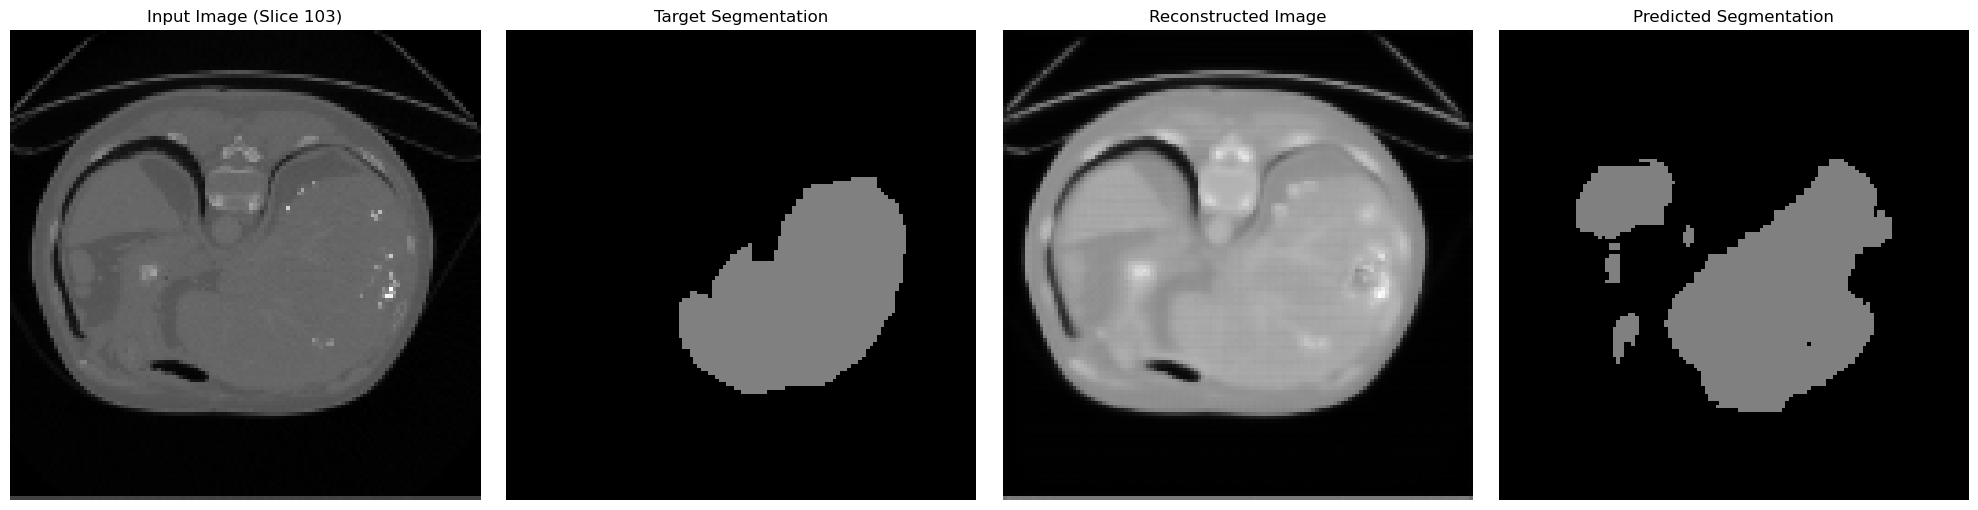

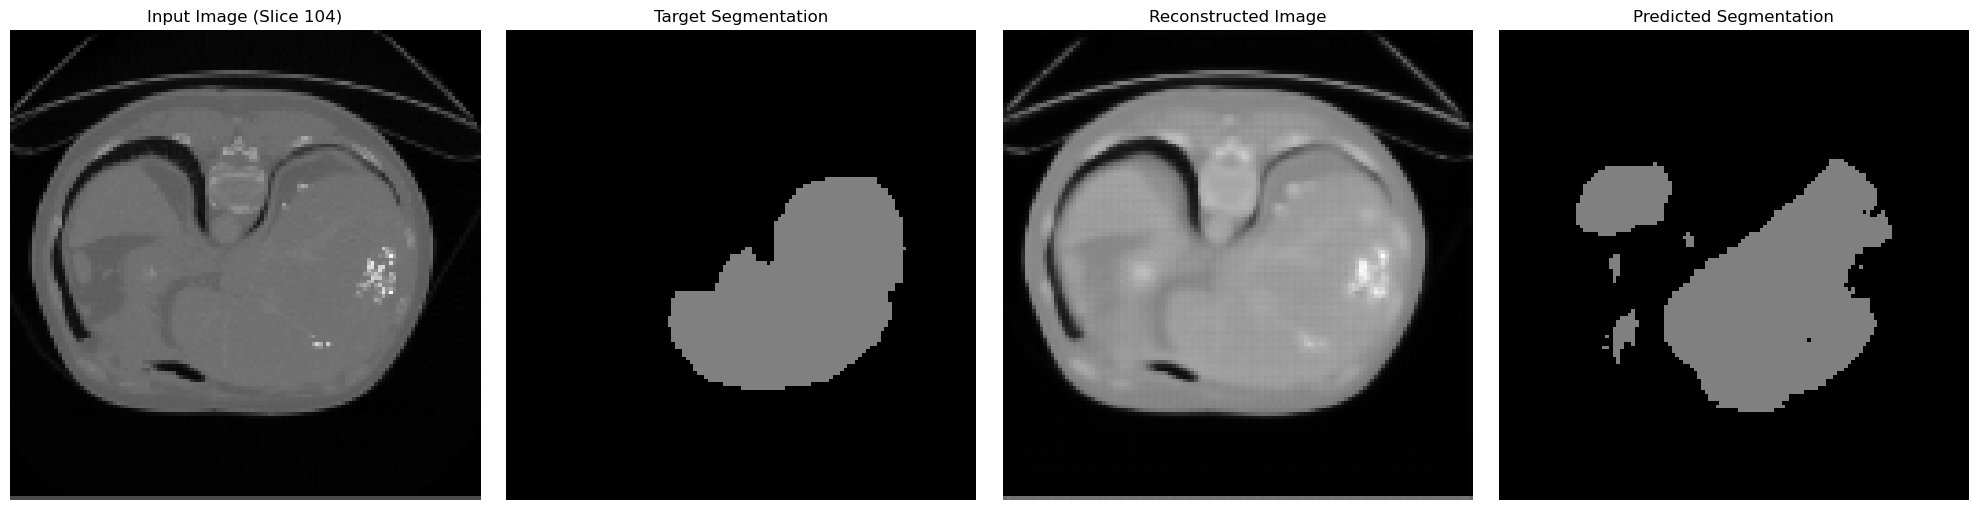

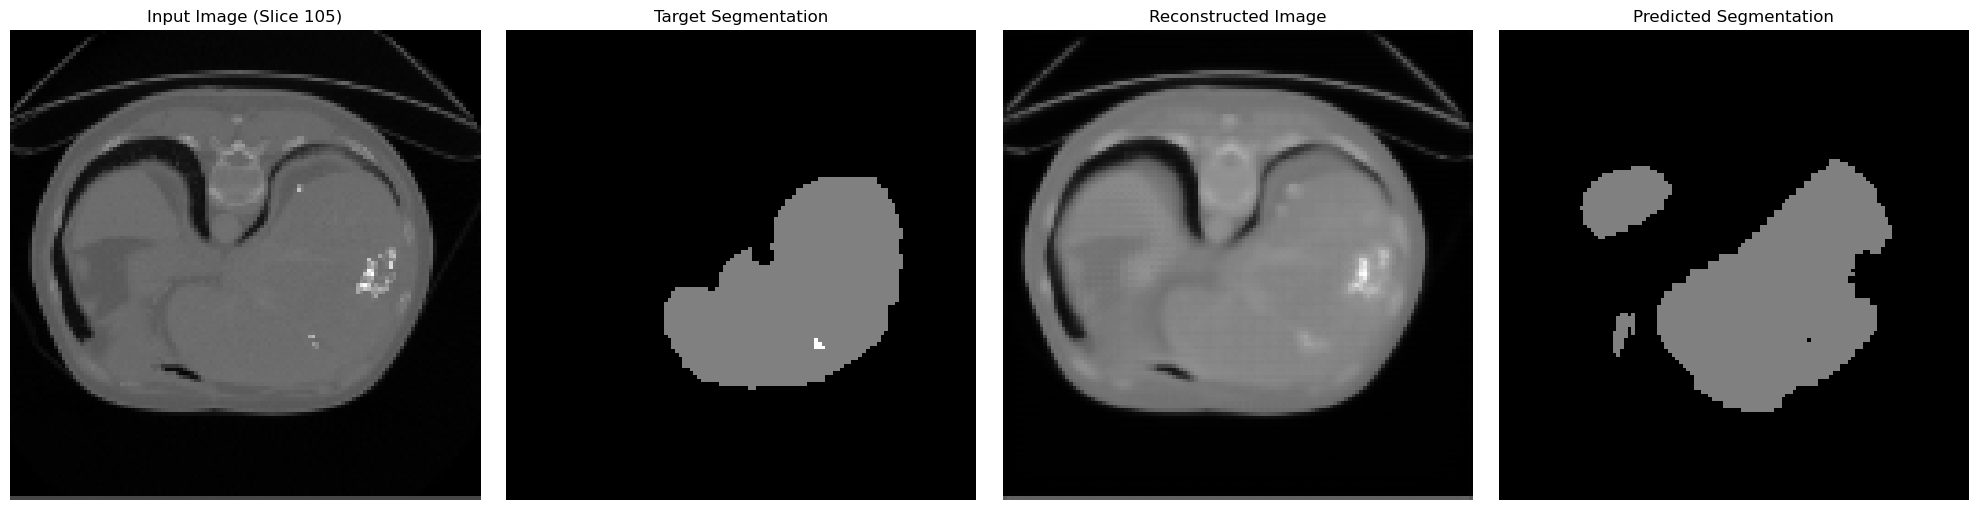

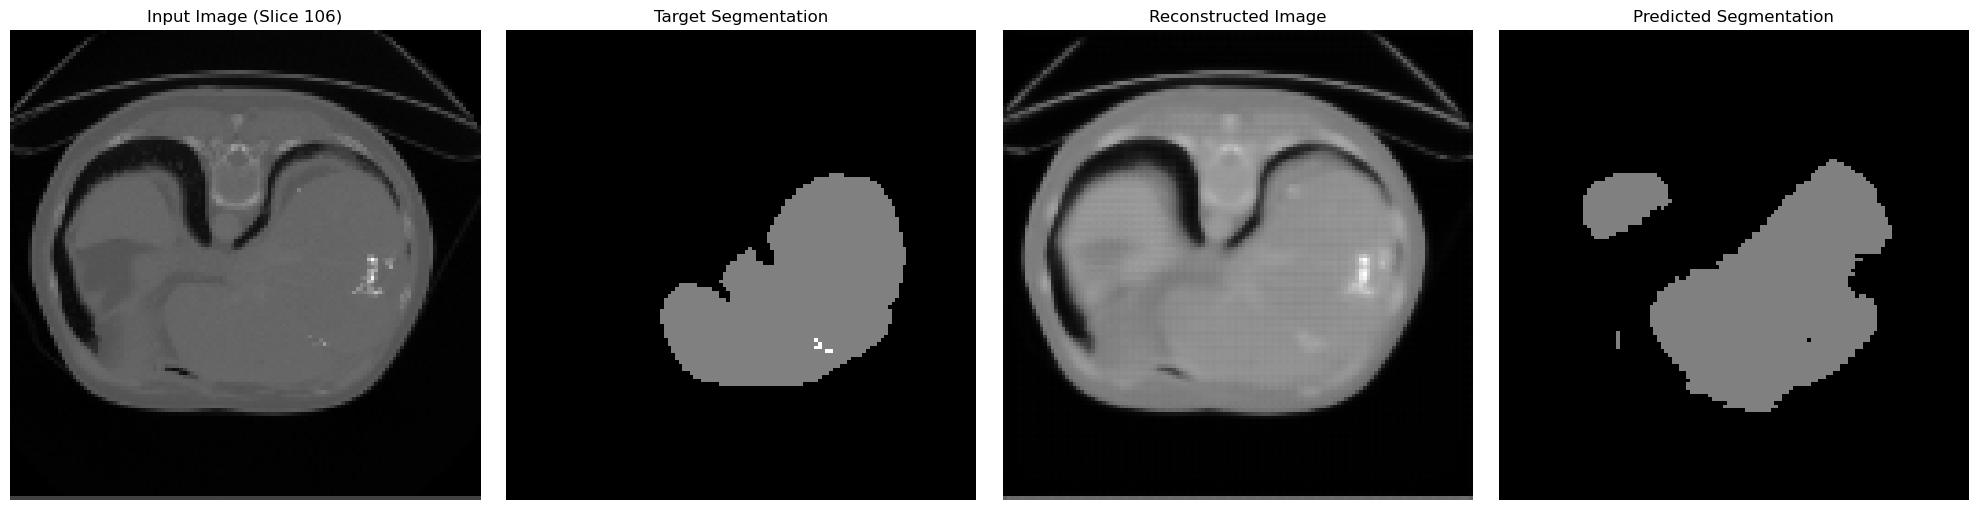

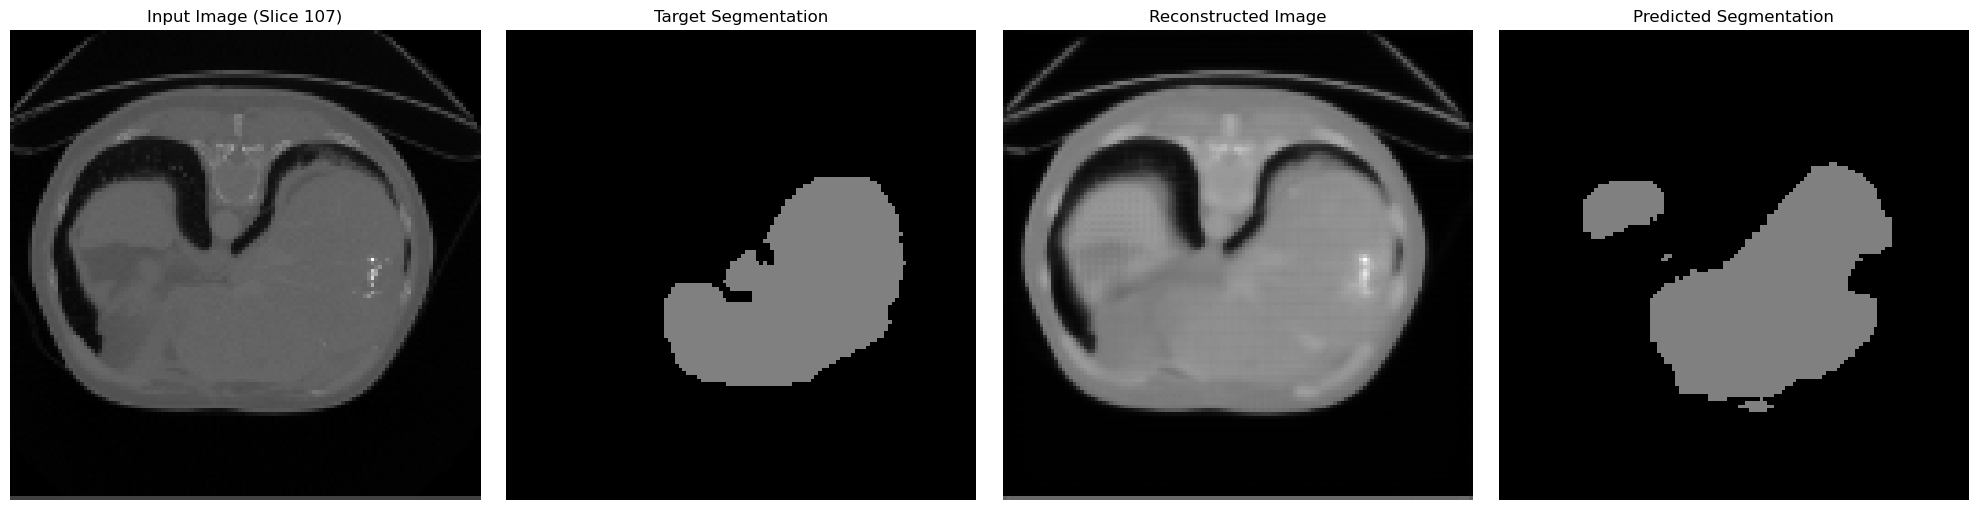

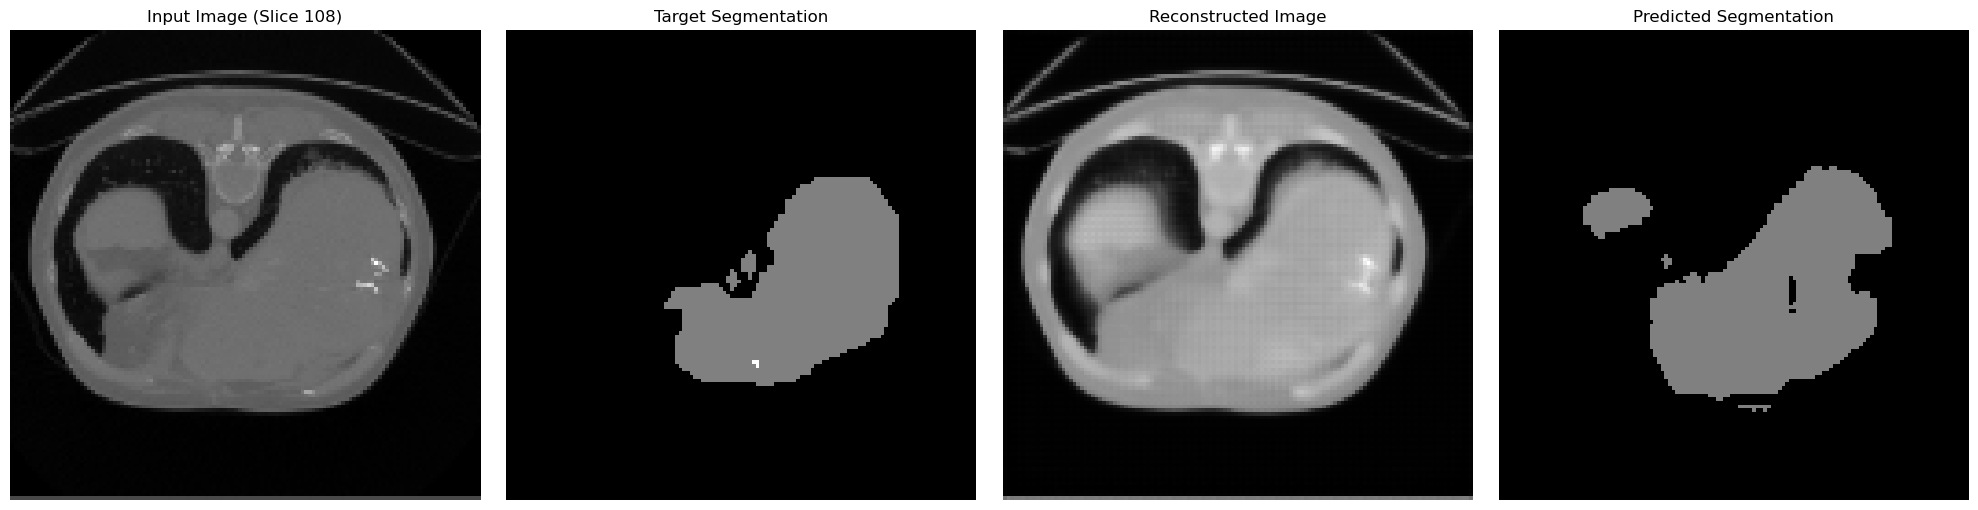

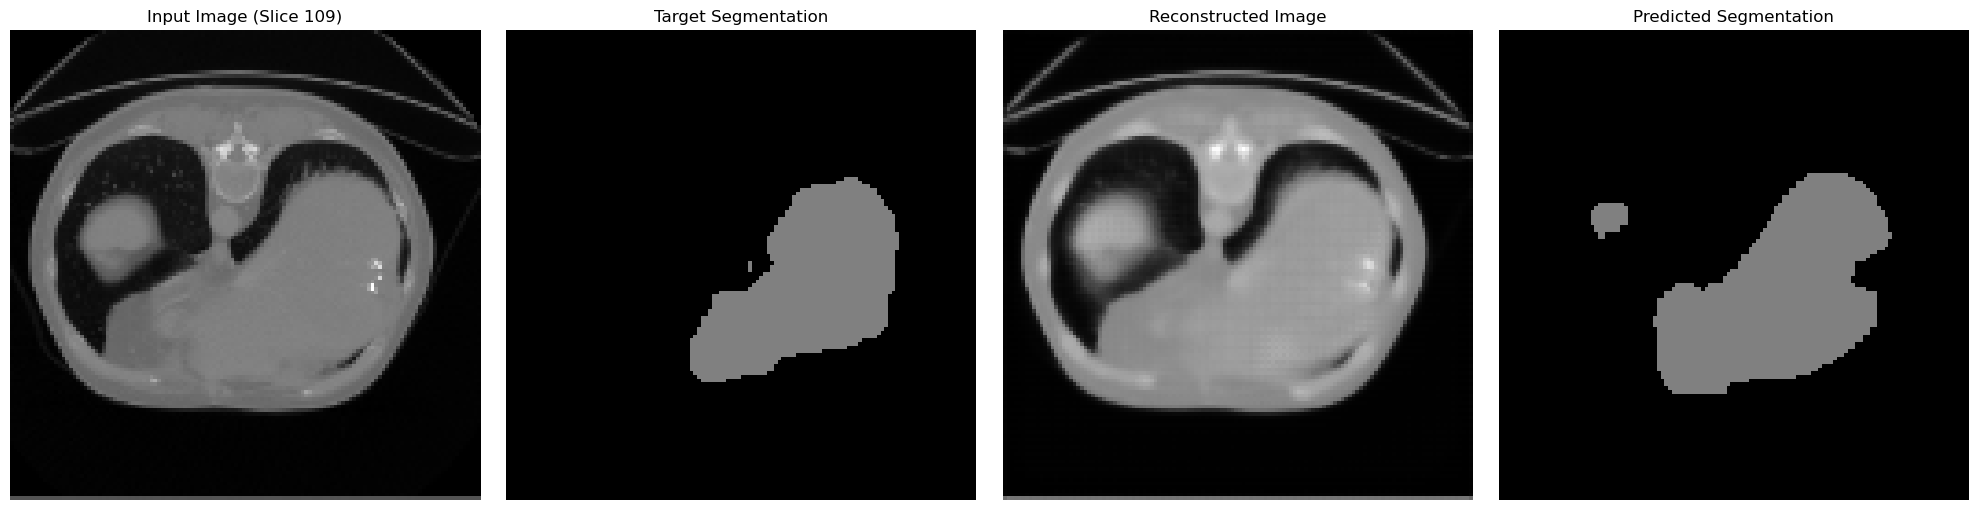

In [39]:
from func.utill import visualize_slices

for i in range(30):
    visualize_slices(x_labeled, y_labeled, recon, seg_out, slice_idx=80+i)




torch.Size([1, 128, 128, 128])
(1, 128, 128, 128)


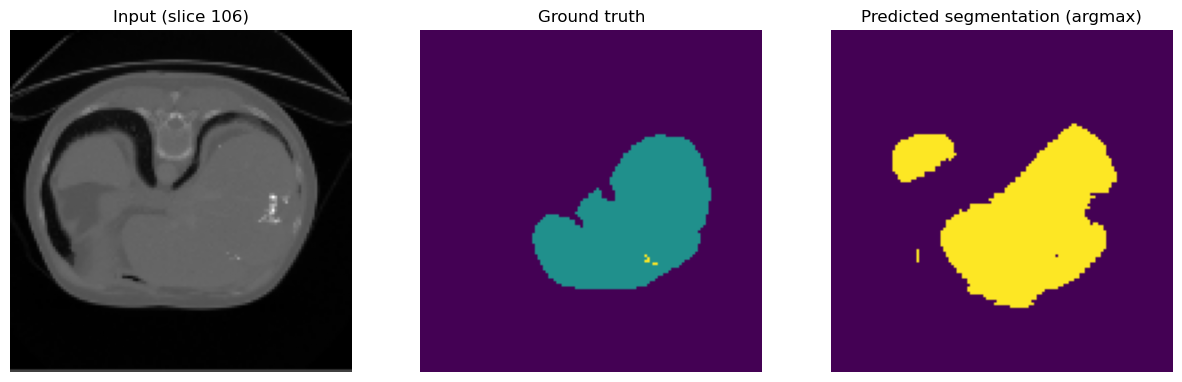

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Convert prediction to class map (assumes seg_out shape: (B, C, D, H, W))
pred = torch.argmax(seg_out, dim=1)  # (B, D, H, W)
print(pred.shape)
# Move to CPU / numpy
pred_np = pred.detach().cpu().numpy()
x_np = x_labeled.detach().cpu().numpy()
y_np = y_labeled.detach().cpu().numpy()

print(pred_np.shape)

# Choose slice index (change this value as needed)
slice_idx = 106

# Handle possible shapes: x -> (B,1,D,H,W) or (B,D,H,W); y -> (B,1,D,H,W) or (B,D,H,W)
img = x_np[0,0,slice_idx] if x_np.ndim == 5 else x_np[0,slice_idx]
gt = y_np[0,0,slice_idx] if y_np.ndim == 5 else y_np[0,slice_idx]
pred_mask = pred_np[0,slice_idx, :, :]

fig, axs = plt.subplots(1,3, figsize=(15,6))
axs[0].imshow(img, cmap='gray')
axs[0].set_title(f'Input (slice {slice_idx})')
axs[1].imshow(gt, cmap='viridis')
axs[1].set_title('Ground truth')
axs[2].imshow(pred_mask, cmap='viridis')
axs[2].set_title('Predicted segmentation (argmax)')
for ax in axs: ax.axis('off')
plt.show()